# Exercise 2: Image denoising

In [1]:
from torch import nn
import torch
import torchvision
import numpy as np
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

# Uncomment the device you want to use
# device = 'cpu'
device = 'cuda'
# device = 'mps'

## Data loading

In [2]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_reconstruction_dataset = FashionMNIST(
    "./data", download=True, transform=transform, train=True
)
train_reconstruction_loader = DataLoader(
    train_reconstruction_dataset, batch_size=64, shuffle=True
)

validation_reconstruction_dataset = FashionMNIST(
    "./data", download=True, transform=transform, train=False
)
validation_reconstruction_loader = DataLoader(
    train_reconstruction_dataset, batch_size=64, shuffle=False
)

100%|██████████| 26421880/26421880 [00:11<00:00, 2294311.56it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 138723.94it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2736010.99it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23019485.07it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## Base model definition

In [3]:
class ReconstructionModel(nn.Module):
    def __init__(self, channels=1, height=28, width=28):
        super(ReconstructionModel, self).__init__()
        self.crop = torchvision.transforms.CenterCrop((height, width))
        self.encoder = nn.Sequential(
            nn.Conv2d(channels, 32, 3, padding="same", padding_mode="replicate"),
            nn.SiLU(),
            nn.MaxPool2d(2, padding=1),
            nn.Conv2d(32, 16, 3, padding="same", padding_mode="replicate"),
            nn.SiLU(),
            nn.MaxPool2d(2, padding=1),
            nn.Conv2d(16, 8, 3, padding="same", padding_mode="replicate"),
            nn.SiLU(),
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding="same", padding_mode="replicate"),
            nn.SiLU(),
            nn.Upsample(scale_factor=2, mode="bilinear"),
            nn.Conv2d(16, 32, 3, padding="same", padding_mode="replicate"),
            nn.SiLU(),
            nn.Upsample(scale_factor=2, mode="bilinear"),
            nn.Conv2d(32, channels, 3, padding="same", padding_mode="replicate"),
            nn.SiLU(),
            nn.Conv2d(channels, channels, 3, padding="same", padding_mode="replicate"),
        )

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return torch.clip(self.crop(x), 0, 1)

### PSNR metric

In [4]:
import torch.nn.functional as F

def psnr(y_pred, y):
    mse = F.mse_loss(y_pred, y)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0  # Since the images are normalized to [0, 1]
    psnr_value = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr_value.item()

### SSIM metric

In [5]:
import torch
import torch.nn.functional as F

def gaussian(window_size, sigma):
    gauss = torch.tensor([np.exp(-(x - window_size // 2) ** 2 / (2 * sigma ** 2)) for x in range(window_size)])
    return gauss / gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def ssim(y_pred, y, window_size=11, C1=np.square(0.01), C2=np.square(0.032)):
    channel = y.size(1)
    window = create_window(window_size, channel).to(y.device)

    mu1 = F.conv2d(y_pred, window, padding=window_size//2, groups=channel)
    mu2 = F.conv2d(y, window, padding=window_size//2, groups=channel)

    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(y_pred * y_pred, window, padding=window_size//2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(y * y, window, padding=window_size//2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(y_pred * y, window, padding=window_size//2, groups=channel) - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

## Model trainer

In [8]:
import matplotlib.pyplot as plt

def ssim_and_psnr(y_pred, y):
    return ssim(y_pred, y), psnr(y_pred, y)

def trainer(
    model,
    epochs,
    train_loader,
    val_loader,
    criterion,
):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for i, (y, _) in enumerate(train_loader):
            y = y.to(device)
            x = torch.clip(y + 0.2 * torch.randn_like(y), 0, 1)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.step()
            # Visualization HERE
            if epoch == 0 or epoch == epochs // 2 or epoch == epochs - 1:
                if i == 0:
                    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
                    axes[0].imshow(y[0].squeeze().cpu().numpy(), cmap='gray')
                    axes[0].set_title('Original')
                    axes[0].axis('off')
                    axes[1].imshow(x[0].squeeze().cpu().numpy(), cmap='gray')
                    axes[1].set_title('Noisy')
                    axes[1].axis('off')
                    axes[2].imshow(y_pred[0].squeeze().cpu().detach().numpy(), cmap='gray')
                    axes[2].set_title('Denoised')
                    axes[2].axis('off')
                    plt.show()
        print(f"Epoch: {epoch}, Loss: {total_loss/len(train_loader)}")

        model.eval()
        with torch.no_grad():
            psnr_metrics, ssim_metrics = 0, 0
            for i, (y, _) in enumerate(val_loader):
                y = y.to(device)
                x = torch.clip(y + 0.2 * torch.randn_like(y), 0, 1)
                y_pred = model(x)
                metrics = ssim_and_psnr(y_pred, y)
                ssim_metrics += metrics[0]
                psnr_metrics += metrics[1]
                # TODO: Add here the visualization of the images
            print(
                f"Epoch: {epoch}, SSIM: {ssim_metrics/len(val_loader)}, PSNR: {psnr_metrics/len(val_loader)}"
            )

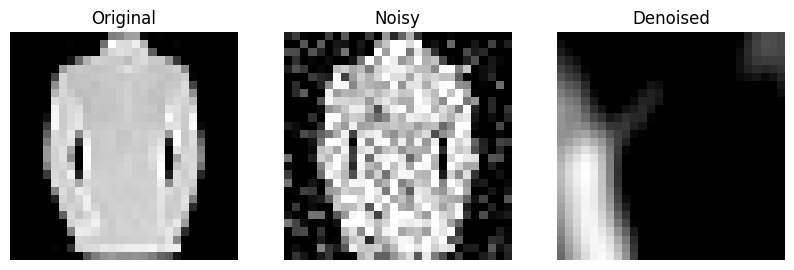

Epoch: 0, Loss: 0.041638618444344765
Epoch: 0, SSIM: 0.7181583046913147, PSNR: 17.498392953038977
Epoch: 1, Loss: 0.015865803812382253
Epoch: 1, SSIM: 0.7556454539299011, PSNR: 18.40082972390311
Epoch: 2, Loss: 0.014038000406741078
Epoch: 2, SSIM: 0.7677809000015259, PSNR: 18.758582493389593
Epoch: 3, Loss: 0.01304524024126372
Epoch: 3, SSIM: 0.778484046459198, PSNR: 19.048364185829406
Epoch: 4, Loss: 0.012383592223673105
Epoch: 4, SSIM: 0.7852070331573486, PSNR: 19.239660574174895
Epoch: 5, Loss: 0.011893709931872103
Epoch: 5, SSIM: 0.789790689945221, PSNR: 19.40146901104242
Epoch: 6, Loss: 0.011469426299772982
Epoch: 6, SSIM: 0.793904185295105, PSNR: 19.49434388776832
Epoch: 7, Loss: 0.011126824222735442
Epoch: 7, SSIM: 0.7990219593048096, PSNR: 19.526053711295383
Epoch: 8, Loss: 0.010837119430112941
Epoch: 8, SSIM: 0.8048717379570007, PSNR: 19.761502316765693
Epoch: 9, Loss: 0.010579227612836401
Epoch: 9, SSIM: 0.8061527609825134, PSNR: 19.859654229332897
Epoch: 10, Loss: 0.01035898

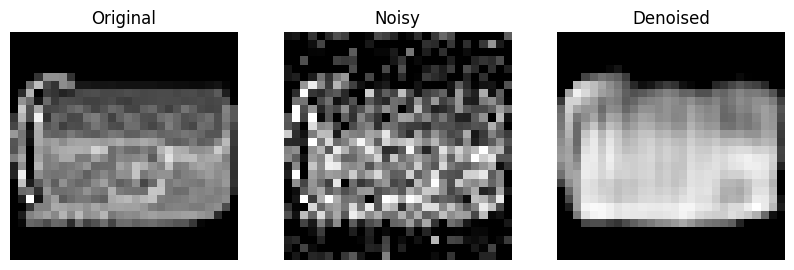

Epoch: 25, Loss: 0.008781572117277587
Epoch: 25, SSIM: 0.8287832736968994, PSNR: 20.539666070104406
Epoch: 26, Loss: 0.008720429479154442
Epoch: 26, SSIM: 0.8317593336105347, PSNR: 20.581989878022085
Epoch: 27, Loss: 0.008662047571063772
Epoch: 27, SSIM: 0.8335142731666565, PSNR: 20.696215932557323
Epoch: 28, Loss: 0.008618252861724575
Epoch: 28, SSIM: 0.8332129716873169, PSNR: 20.65663835488911
Epoch: 29, Loss: 0.008560214911017622
Epoch: 29, SSIM: 0.8353395462036133, PSNR: 20.750654753337283
Epoch: 30, Loss: 0.008539587466308335
Epoch: 30, SSIM: 0.834194004535675, PSNR: 20.75600364416647
Epoch: 31, Loss: 0.008486817659401118
Epoch: 31, SSIM: 0.8352645635604858, PSNR: 20.686823987249117
Epoch: 32, Loss: 0.008457126948775958
Epoch: 32, SSIM: 0.8363686800003052, PSNR: 20.794843960418376
Epoch: 33, Loss: 0.008398276888259025
Epoch: 33, SSIM: 0.8341039419174194, PSNR: 20.69714984202436
Epoch: 34, Loss: 0.008379484508444729
Epoch: 34, SSIM: 0.8378798365592957, PSNR: 20.83391389867136
Epoch

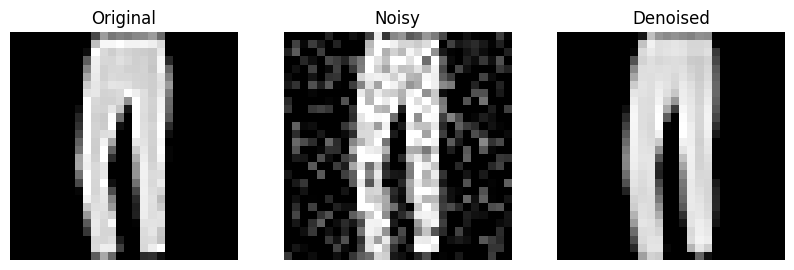

Epoch: 49, Loss: 0.008014555420301585
Epoch: 49, SSIM: 0.8431200385093689, PSNR: 21.03824654113509


In [9]:
criterion = nn.MSELoss()
model = ReconstructionModel().to(device)
trainer(
    model,
    50,
    train_reconstruction_loader,
    validation_reconstruction_loader,
    criterion,
)

In [10]:
class ReconstructionModelConvTranspose(ReconstructionModel):
    def __init__(self, channels=1, height=28, width=28):
        super(ReconstructionModelConvTranspose, self).__init__(channels, height, width)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Upsampling
            nn.SiLU(),
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Upsampling
            nn.SiLU(),
            nn.Conv2d(32, channels, kernel_size=3, padding=1) #final convolution
        )
        self.init_weights()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return torch.clip(self.crop(x), 0, 1)


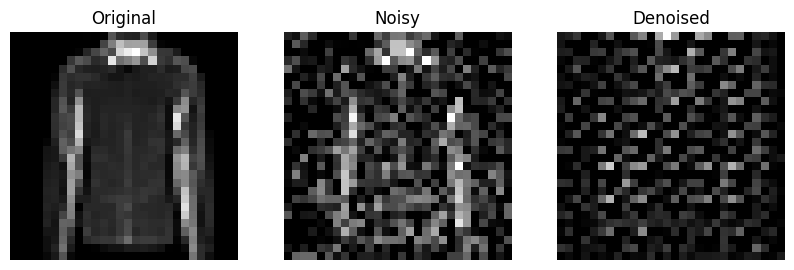

Epoch: 0, Loss: 0.023626221205864443
Epoch: 0, SSIM: 0.7462561726570129, PSNR: 18.37673704151406
Epoch: 1, Loss: 0.012763164515521671
Epoch: 1, SSIM: 0.784028172492981, PSNR: 19.349053580115346
Epoch: 2, Loss: 0.011135262953463013
Epoch: 2, SSIM: 0.7994385957717896, PSNR: 19.779517934266437
Epoch: 3, Loss: 0.010273629692254036
Epoch: 3, SSIM: 0.8095331788063049, PSNR: 20.04431914673177
Epoch: 4, Loss: 0.00970873930183714
Epoch: 4, SSIM: 0.8173457980155945, PSNR: 20.291740022996848
Epoch: 5, Loss: 0.009277021123676189
Epoch: 5, SSIM: 0.8220394253730774, PSNR: 20.383537516156746
Epoch: 6, Loss: 0.008991386048368681
Epoch: 6, SSIM: 0.8241459131240845, PSNR: 20.451702699478247
Epoch: 7, Loss: 0.00874660869013828
Epoch: 7, SSIM: 0.8303608894348145, PSNR: 20.693060754967142
Epoch: 8, Loss: 0.008566121890473722
Epoch: 8, SSIM: 0.8321378827095032, PSNR: 20.743091941134
Epoch: 9, Loss: 0.00839512060080637
Epoch: 9, SSIM: 0.8346716165542603, PSNR: 20.838384408686462
Epoch: 10, Loss: 0.0082727835

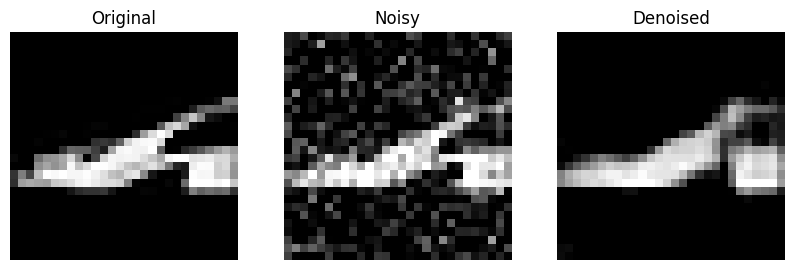

Epoch: 25, Loss: 0.007337363421924905
Epoch: 25, SSIM: 0.8514431715011597, PSNR: 21.383458389656376
Epoch: 26, Loss: 0.007304475774297487
Epoch: 26, SSIM: 0.8523615002632141, PSNR: 21.401998190483305
Epoch: 27, Loss: 0.00727572865577649
Epoch: 27, SSIM: 0.852798342704773, PSNR: 21.364656863182084
Epoch: 28, Loss: 0.007244931056356824
Epoch: 28, SSIM: 0.8515230417251587, PSNR: 21.374851802264704
Epoch: 29, Loss: 0.0072140564788569774
Epoch: 29, SSIM: 0.8538142442703247, PSNR: 21.486268891454504
Epoch: 30, Loss: 0.0071992746724097775
Epoch: 30, SSIM: 0.8530580997467041, PSNR: 21.424963875874273
Epoch: 31, Loss: 0.007174271562976687
Epoch: 31, SSIM: 0.8533148169517517, PSNR: 21.483673630492774
Epoch: 32, Loss: 0.007133227478621452
Epoch: 32, SSIM: 0.8514963388442993, PSNR: 21.500884668150945
Epoch: 33, Loss: 0.007127970348356534
Epoch: 33, SSIM: 0.8539182543754578, PSNR: 21.50626473335315
Epoch: 34, Loss: 0.0071130184568901625
Epoch: 34, SSIM: 0.8546218276023865, PSNR: 21.521662110204634


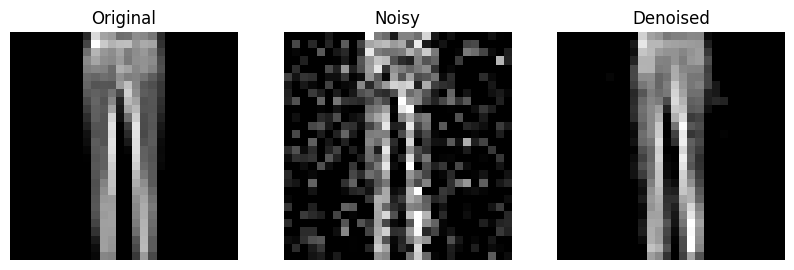

Epoch: 49, Loss: 0.0068808256148068766
Epoch: 49, SSIM: 0.8572335243225098, PSNR: 21.669420173173265


In [11]:
model2 = ReconstructionModelConvTranspose(1, 28, 28).to(device)
trainer(
    model2,
    50,
    train_reconstruction_loader,
    validation_reconstruction_loader,
    criterion,
)